## Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import random as rand
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [2]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, etc.

In [3]:
BOX_LEN=300  # Box length
DIM=600      # Number of Voxels for hight resolution 
HII_DIM=300  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

## Creating initial conditions box

In [4]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Plotting slices of Neutral fractions.

def simple_xH_plot(ion: p21c.outputs.IonizedBox, ax: plt.Axes):
    return ax.imshow(ion.xH_box[:, :, 0].T, extent=(0,200,0,200), vmin=0, vmax=1, origin='lower')

fig, ax = plt.subplots(2, 4, figsize=(14,6), sharex=True, sharey=True, gridspec_kw={"hspace":0.25, 'wspace': 0.05})

for i, z in enumerate([20, 12, 10, 9, 8, 7, 6, 5]):
    ion = p21c.ionize_box(redshift=z, init_boxes=init_cond)
    im = simple_xH_plot(ion, ax.flatten()[i])
    ax.flatten()[i].set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
    
cbar = plt.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label("Neutral Fraction")

## Average Neutral Fraction vs. Redshift

lightcone = p21c.run_lightcone(
    redshift = 6,
    max_redshift = 8,
    init_box=init_cond,
    lightcone_quantities=(
        'brightness_temp',
        'xH_box',
    ),
    global_quantities=(
        'brightness_temp',
        'xH_box'
    )
)

p21c.plotting.plot_global_history(lightcone, kind='xH_box')
plt.title("Neutral Freaction vs. Redshift")

## Subject Ionized Box

z=6.5
ionized = p21c.ionize_box(
    redshift=z,
    init_boxes=init_cond
)
subject_box = ionized.xH_box
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond)

## Slice of Subject Box

plt.imshow(subject_box[:, :, 0], origin='lower')
plt.title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}")
plt.colorbar(label="Neutral Fraction")

## Square Blurring Function

In [182]:
def Square_Blurring(box, radius, interation):
    box = box.copy()
    for i in range(interation):
        rand_x = rand.randint(radius, BOX_LEN - 1 - radius)  # ensure that the random center point won't be at the edge of the cube
        rand_y = rand.randint(radius, BOX_LEN - 1 - radius)
        rand_z = rand.randint(radius, BOX_LEN - 1 - radius)
        
        cube_region = box[rand_x-radius:rand_x+radius+1, rand_y-radius:rand_y+radius+1, rand_z-radius:rand_z+radius+1]
        neutral_mean = np.mean(cube_region)
        box[rand_x-radius:rand_x+radius+1, rand_y-radius:rand_y+radius+1, rand_z-radius:rand_z+radius+1] = neutral_mean
    return box

In [243]:
def Sphere_Blurring(box, radius, interation):
    box = box.copy()
    for i in range(interation):
        rand_coord = np.random.randint(radius, BOX_LEN - 1 - radius, size=3)  # ensure that the random center point won't be at the edge of the cube
        
        cube_region = box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1]
        
        keys_index_x = np.arange(np.shape(cube_region)[0])
        keys_index_y = np.arange(np.shape(cube_region)[1])
        keys_index_z = np.arange(np.shape(cube_region)[2])
        
        keys_x, keys_y, keys_z = np.meshgrid(keys_index_x, keys_index_y, keys_index_z)

        sphere_condition = np.sqrt((keys_x-rand_coord[0])**2 + (keys_y-rand_coord[1])**2 + (keys_z-rand_coord[2])**2) <= radius
        
        inside_sphere_mean = np.mean(cube_region[sphere_condition])
        
        cube_region = np.where(sphere_condition, inside_sphere_mean, cube_region)
        
        box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1] = cube_region  
    return box

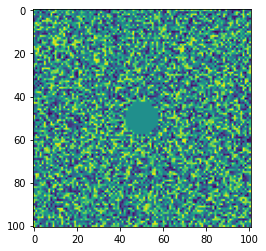

In [223]:
test_box = np.random.rand(101,101,101)
test_center = [0.5*(np.shape(test_box)[0]-1), 0.5*(np.shape(test_box)[1]-1), 0.5*(np.shape(test_box)[2]-1)]

true_false_index_x = np.arange(np.shape(test_box)[0])
true_false_index_y = np.arange(np.shape(test_box)[1])
true_false_index_z = np.arange(np.shape(test_box)[2])
test_x, test_y, test_z = np.meshgrid(true_false_index_x, true_false_index_y, true_false_index_z)

circle_condition = np.sqrt((test_x - test_center[0])**2 + (test_y - test_center[1])**2 + (test_z - test_center[2])**2) <= 30
inside_circle_mean = np.mean(test_box[circle_condition])
test_box = np.where(circle_condition, inside_circle_mean, test_box)

plt.imshow(test_box[:,:,21])

In [163]:
np.shape(test_box)[0]

6

In [139]:
x_values = np.arange(20)
condition = np.logical_and(7 <= x_values, x_values <= 14)
x_values[condition]

array([ 7,  8,  9, 10, 11, 12, 13, 14])

In [144]:
x = np.arange(20)
avg_1 = x[np.logical_and(7 <= x, x <= 14)].mean()
avg_2 = np.where(np.logical_and(7 <= x, x <= 14), x, 0).mean()
avg_1 == avg_2



False

In [101]:
U, V = Square_Blurring(ionized, 30, 10**3)
print(V)

(61, 61, 61)


In [126]:
x = np.arange(100).reshape(10,10)
print(x)
x[3:7,1:5] = np.where(x[3:7,1:5] % 2, 0, x[3:7,1:5])
print(x)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30  0 32  0 34 35 36 37 38 39]
 [40  0 42  0 44 45 46 47 48 49]
 [50  0 52  0 54 55 56 57 58 59]
 [60  0 62  0 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


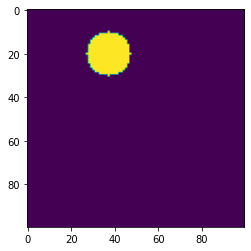

In [135]:
# start with a 100 x 100 square grid
Nside = 100
base_indices = np.arange(Nside)
x_indices, y_indices = np.meshgrid(base_indices, base_indices)
reference_position_indices = np.array([37, 20])
# disk = np.where(np.sqrt((x_indices - reference_position_indices[0])**2 + (y_indices - reference_position_indices[1])**2)<= 10, 1, 0)
np.sqrt((x_indices - reference_position_indices[0])**2 + (y_indices - reference_position_indices[1])**2)<= 10
plt.imshow(disk)

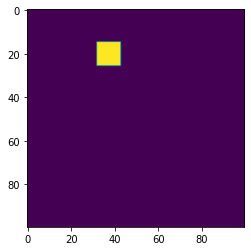

In [123]:
square = np.where(np.logical_and(np.abs(x_indices - reference_position_indices[0]) <= 5, np.abs(y_indices - reference_position_indices[1]) <= 5), 1, 0)
plt.imshow(square)

In [113]:
conditional_array = [True,] * 5 + [False,] * 5
positive_integers = np.arange(len(conditional_array))
negative_integers = -positive_integers
test_result = np.where(conditional_array, positive_integers, negative_integers)
print(positive_integers)

[0 1 2 3 4 5 6 7 8 9]


## Blurring the Subject Box

blurred_box = Square_Blurring(subject_box, 1, 10**7)

## Plotting

In [225]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(blurred_box[:, :, 0], origin='lower')
ax1.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img1)

img2 = ax2.imshow(subject_box[:, :, 0], origin='lower')
ax2.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
colorbar(img2)

plt.tight_layout(h_pad=1)

In [247]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

In [280]:
Sphere_blurred = Sphere_Blurring(np.random.rand(300,300,300), 100, 10**2)

In [281]:
ionized is Sphere_blurred

False

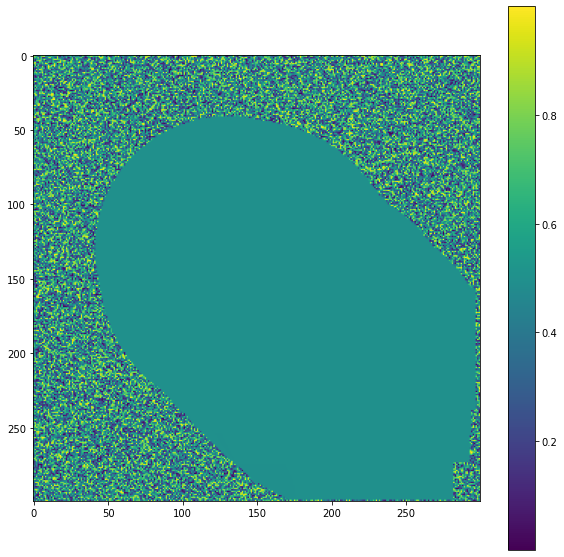

In [285]:
plt.figure(figsize=(10,10))
plt.imshow(Sphere_blurred[:,:,150])
plt.colorbar()

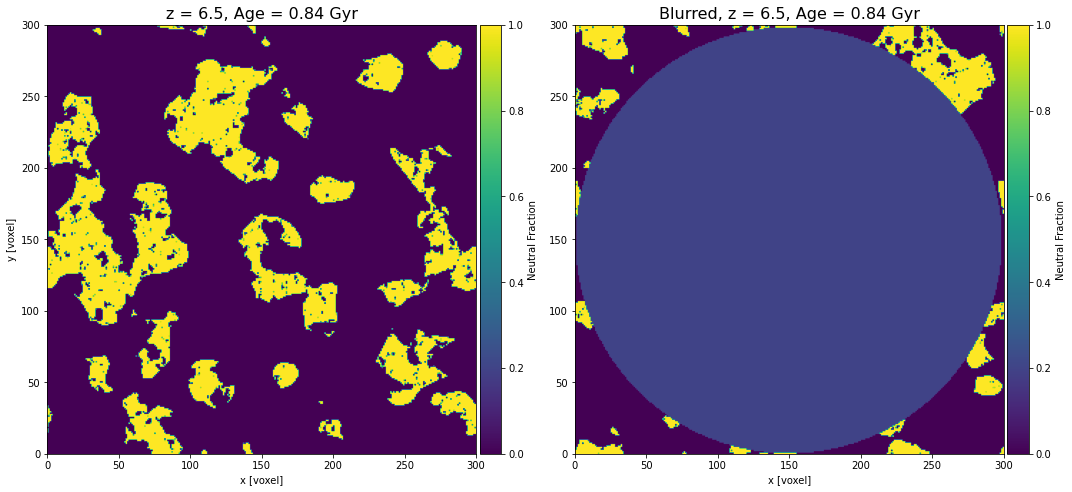

In [287]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Sphere_Blurring(ionized, 149, 1)[:, :, 150], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

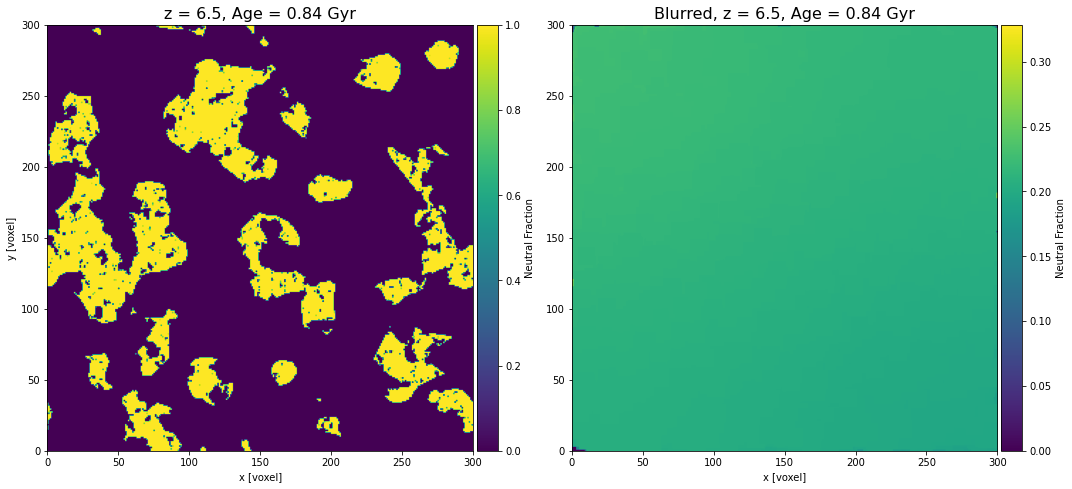

In [8]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, 6, 10**7)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

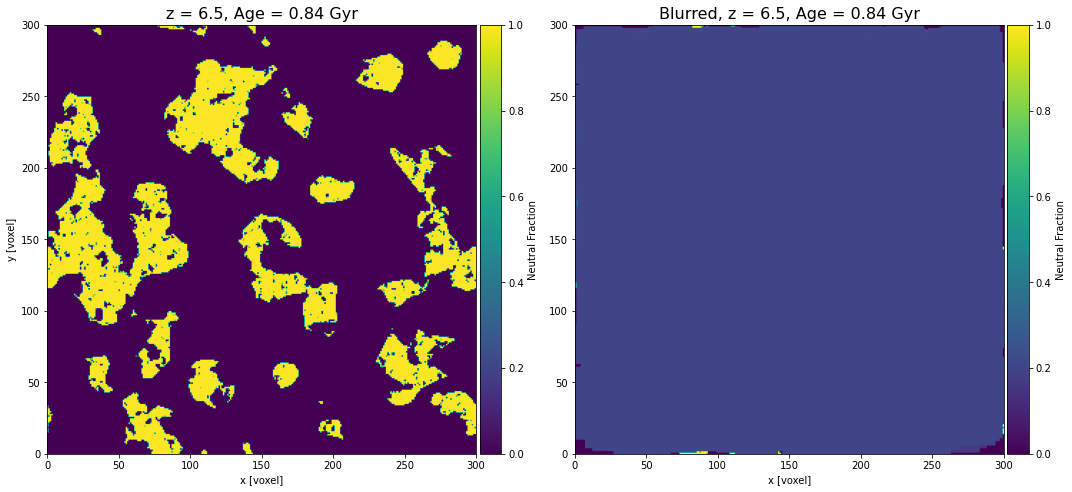

In [9]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Square_Blurring(ionized, 13, 10**6)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 0.]
  [0. 1. 1. 1. 0.]
  [0. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0.]
  [0. 1. 1. 1. 0.]
  [1. 1. 1. 1. 1.]
  [0. 1. 1. 1. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 0.]
  [0. 1. 1. 1. 0.]
  [0. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
33.0
2.0


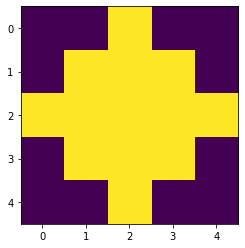

In [71]:
LEN = 5
A = np.zeros((LEN,LEN,LEN))

center_x = 0.5*(LEN-1)
center_y = 0.5*(LEN-1)
center_z = 0.5*(LEN-1)
Radius = 2
for xx in range(LEN):
    for yy in range(LEN):
        for zz in range(LEN):
            dist = np.sqrt((xx - center_x)**2 + (yy - center_y)**2 + (zz - center_z)**2)
            if dist <= Radius:
                A[xx, yy, zz] = 1
print(A)
print(np.sum(A))
print(center_x)
plt.imshow(A[np.int(center_x),:,:])